### Changes camparing to WGAN:
1. add gradient penalty


paper: [Wasserstein GAN](https://arxiv.org/abs/1701.07875)

## 1. Import dataset & data preprocess

See details in utils/data_preprocess.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Example input images:


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


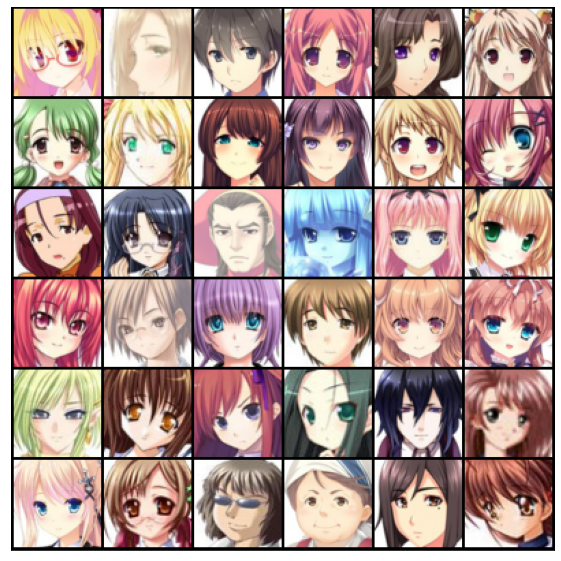

In [2]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/data_preprocess.ipynb

## 2. Load DCGAN base architecture


In [3]:
!pip install torchsummary
import torch.nn as nn
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Inputs for the run:
# Number of workers for dataloader
workers = 2
batch_size = 128
image_size = 64
nc = 3    # Number of channels in the training images. For color images this is 3
latent_size = 128  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
epochs = 20
lr = 0.0002
betas = (0.5, 0.999)
ngpu = 1  # Number of GPUs available. Use 0 for CPU mode.
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # in: latent_size x 1 x 1
            #512 = ngf * 8
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            #nn.Sigmoid()-- No sigmoid in WGAN network
        )

    def forward(self, input):
        return self.main(input)

In [7]:
generator = Generator()
discriminator = Discriminator()

In [8]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of generator:' + color.END)

print(summary(generator,(latent_size,1,1)))

Architecture of generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
            

In [9]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of discriminator:' + color.END)
print(summary(discriminator,(3,64,64)))

Architecture of discriminator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
        

torch.Size([128, 3, 64, 64])


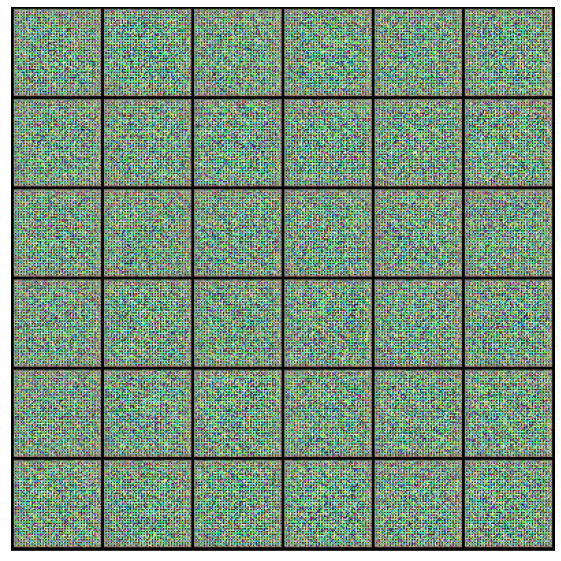

In [10]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

## Train

In [24]:
DEVICE           = "cuda" if torch.cuda.is_available() else "cpu"
LR               = 1e-4
BS               = 128
IMG_SIZE         = 64
CHANNELS_IMG     = 3
Z_DIM            = 128
NUM_EPOCHS       = 5
FEATURES_CRITIC  = 16
FEATURES_GEN     = 16
CRITIC_ITERATIONS= 5
LAMBDA_GP        = 10

In [12]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs       = interpolated_images,
        outputs      = mixed_scores,
        grad_outputs = torch.ones_like(mixed_scores),
        create_graph = True,
        retain_graph = True,
    )[0]
    gradient         = gradient.view(gradient.shape[0], -1)
    gradient_norm    = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="emoji_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [13]:
gen    = Generator().to(device)
critic = Discriminator().to(device)
initialize_weights(gen)
initialize_weights(critic)
# initializate optimizer
opt_gen    = torch.optim.Adam(gen.parameters(), lr=LR, betas=(0.0, 0.9))
opt_critic = torch.optim.Adam(critic.parameters(), lr=LR, betas=(0.0, 0.9))
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

In [14]:
unnormalize = transforms.Normalize(mean=[-0.5/0.5 for _ in range(CHANNELS_IMG)],  #-mean/std
            std=[1.0/0.5 for _ in range(CHANNELS_IMG)]) 

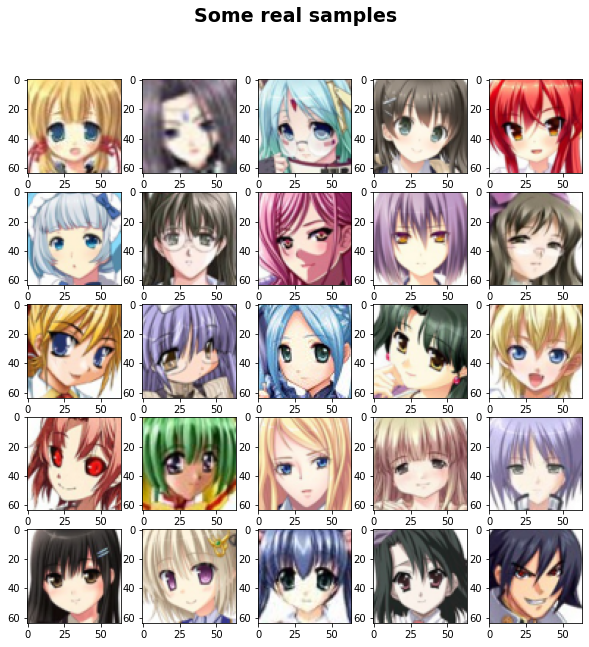

In [15]:
real, y = next(iter(train_dl))
_, ax = plt.subplots(5,5, figsize=(10,10))
plt.suptitle('Some real samples', fontsize=19, fontweight='bold')

ind = 0 
for k in range(5):
    for kk in range(5):
        ind += 1
        ax[k][kk].imshow(unnormalize(real[ind]).permute(1,2,0))

In [ ]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(train_dl):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
    if batch_idx % 100 == 0 and batch_idx > 0:
        print(
            f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_dl)} \
              Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
        )
    with torch.no_grad():
        fake = gen(fixed_noise).reshape(-1, 3, 64, 64).cpu()
        _, ax = plt.subplots(5,5, figsize=(10,10))
        plt.suptitle('Results of epoch '+str(epoch), fontsize=19, fontweight='bold')

        ind = 0 
        for k in range(5):
            for kk in range(5):
                ind += 1
                ax[k][kk].imshow(unnormalize(fake[ind]).permute(1,2,0))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Output visualization & evaluation


In [ ]:
output_dir = '/content/generated_wganGP'

In [ ]:
%run /content/drive/MyDrive/ML_notes/301_Final_proj/codes/utils/eval_and_output.ipynb